## WorkFlow
1. Combine dataset
2. Feature Engineering
3. Model Building

<ul>
    <b>I. Data Preprocessing</b>
    <li>a. Dataframe</li>
    <li>b. Feature Engineering</li>
</ul>

<ul>
    <b>II. Supervised Learning</b>
    <li>a. ml models</li>
    <li>d. AUC-ROC Comparison</li>
    <li>f. Best Model Feature Importance</li>
</ul>



## I. Data Preprocessing

In [1]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


import re
import json
import numpy as np
from random import shuffle
from sklearn.svm import SVC
from sklearn import neighbors
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

from sklearn.metrics import accuracy_score, recall_score,classification_report 

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings('ignore')


In [73]:
# Define chunksize and initialize an empty DataFrame to store the results
chunksize = 10000

data_review = pd.DataFrame()
# Iterate over the file in chunks and concatenate the results
for chunk in pd.read_json('/Users/Ethan Vaz Falcao/Downloads/Yelp_data/yelp_academic_dataset_review.json', lines=True, chunksize=chunksize):
    data_review = pd.concat([data_review, chunk], ignore_index=True)

In [74]:
# randomly select 1,000,000 rows
data_review = data_review.sample(n=1000000, random_state=42)

# print the first 5 rows of the randomly selected dataframe
data_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
1295256,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
3297618,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
1217795,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48
3730348,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49
1826590,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25


In [75]:
count_by_year = data_review.groupby(data_review['date'].dt.year).size()
print(count_by_year)

date
2005       124
2006       529
2007      2161
2008      6839
2009     10546
2010     19696
2011     33117
2012     41255
2013     55172
2014     74578
2015     98597
2016    108142
2017    116992
2018    129703
2019    129758
2020     79558
2021     88686
2022      4547
dtype: int64


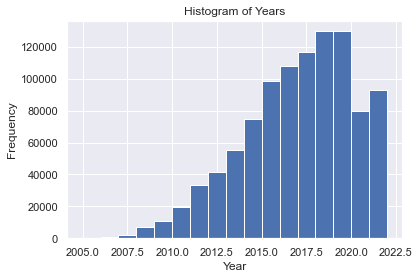

In [76]:
# extract the "date" column
dates = data_review["date"]

# extract the year from each date
years = [date.year for date in dates]

# plot a histogram of the years
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Histogram of Years")
plt.show()


In [77]:
#set the year of the dataset  at 2021 for testing
#data_review_test = data_review[data_review['date'].dt.year >= 2018]
#data_review_test = data_review[data_review['date'].dt.year >= 2020]

In [78]:
data_review.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
1295256,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
3297618,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
1217795,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48


### Step 1: DataFrame

In [79]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize sentiment analysis model
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# apply model to reviews and assign labels
data_review['label'] = data_review['text'].apply(lambda x: 1 if sia.polarity_scores(x)['compound'] > 0 else -1)

# print head of resulting dataset
data_review.head(3)
 

[nltk_data] Downloading package vader_lexicon to C:\Users\Ethan Vaz
[nltk_data]     Falcao\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,label
1295256,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53,-1
3297618,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14,1
1217795,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48,1


In [80]:
# user_id, prod_id, rating, label, date
#data.columns =['user_id', 'prod_id', 'stars', 'label','date']
data = data_review[['user_id', 'business_id','date','stars', 'text', "label"]]

In [81]:
# check the data description
# no missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 1295256 to 794448
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   user_id      1000000 non-null  object        
 1   business_id  1000000 non-null  object        
 2   date         1000000 non-null  datetime64[ns]
 3   stars        1000000 non-null  int64         
 4   text         1000000 non-null  object        
 5   label        1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 53.4+ MB


In [82]:
#change date to date time
data['date'] = pd.to_datetime(data['date'])

### Step 2: Feature Engineering


In [83]:
data.head()

,user_id,business_id,date,stars,text,label
1295256,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2018-04-04 21:09:53,2,Went for lunch and found that my burger was me...,-1
3297618,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,2020-05-24 12:22:14,5,I needed a new tires for my wife's car. They h...,1
1217795,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,2019-02-14 03:47:48,5,Jim Woltman who works at Goleta Honda is 5 sta...,1
3730348,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,2013-04-27 01:55:49,4,Been here a few times to get some shrimp. The...,1
1826590,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,2019-05-15 18:29:25,5,This is one fantastic place to eat whether you...,1


In [84]:
#1. Maximum number of reviews in a day
review_day=data.groupby(['user_id','date']).count().sort_values(by='text').reset_index()
review_day.head(3)

,user_id,date,business_id,stars,text,label
0,---2PmXbF47D870stH1jqA,2015-01-21 20:39:14,1,1,1,1
1,eg0WSgiKFOL3fgb4Ri1bCQ,2012-07-14 04:33:19,1,1,1,1
2,eg0cwrodeKGLeLIDTSCXoA,2010-08-16 13:43:42,1,1,1,1


In [85]:
max_review=review_day.groupby('user_id').max().reset_index()[['user_id','text']]
max_review.rename(columns={'text':'max_review_on_a_day'},inplace=True)
max_review

,user_id,max_review_on_a_day
0,---2PmXbF47D870stH1jqA,1
1,---UgP94gokyCDuB5zUssA,1
2,---r61b7EpVPkb4UVme5tA,1
3,--17Db1K-KujRuN7hY9Z0Q,1
4,--1oZcRo9-QKOtTqREKB6g,1
...,...,...
558094,zzwTBixpqjeAD_IkMlby0g,1
558095,zzwYLnmIvj8C7wJmRjtkRA,1
558096,zzxZW6U5lCCQQeVfLLU6gw,1
558097,zzyTsajskrf_Ha8gU4HmTA,1


In [86]:
#merge max_review with data
data=pd.merge(data,max_review,on=['user_id'])
data.head(3)

,user_id,business_id,date,stars,text,label,max_review_on_a_day
0,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2018-04-04 21:09:53,2,Went for lunch and found that my burger was me...,-1,1
1,56gL9KEJNHiSDUoyjk2o3Q,oEwmCZknUHgHfEBdKA2SZA,2018-05-16 11:04:31,5,Best Pho in Indy by far and reasonable prices!...,1,1
2,56gL9KEJNHiSDUoyjk2o3Q,8zJYnVNKD7XUHaKFMMREBg,2019-09-23 22:52:23,2,"First of all, if you go to a Mexican restauran...",-1,1


In [87]:
#2. Percentage of reviews with positive / negative ratings (2)

#Assuming positive rating is rating >4 and negative rating is rating <4

In [88]:
(data.groupby(data['stars']
    .apply(lambda x: 'negative' if x < 3 else 'positive' if x > 3 else 'neutral'))['stars']
    .count())

stars
negative    230687
neutral      98714
positive    670599
Name: stars, dtype: int64

In [89]:
# count number of reviews each user_id had written
d=data.groupby('user_id').count().reset_index()[['user_id','text']]
d.rename(columns={'text':'review_count'},inplace=True)

#merge review_count with data
data=pd.merge(data,d,on=['user_id'])
data.head()

,user_id,business_id,date,stars,text,label,max_review_on_a_day,review_count
0,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2018-04-04 21:09:53,2,Went for lunch and found that my burger was me...,-1,1,7
1,56gL9KEJNHiSDUoyjk2o3Q,oEwmCZknUHgHfEBdKA2SZA,2018-05-16 11:04:31,5,Best Pho in Indy by far and reasonable prices!...,1,1,7
2,56gL9KEJNHiSDUoyjk2o3Q,8zJYnVNKD7XUHaKFMMREBg,2019-09-23 22:52:23,2,"First of all, if you go to a Mexican restauran...",-1,1,7
3,56gL9KEJNHiSDUoyjk2o3Q,eB4Lwa8viOfghDJOZq6OMQ,2021-06-16 17:35:56,5,A lesson in preconceived notions. \n\nI've dri...,1,1,7
4,56gL9KEJNHiSDUoyjk2o3Q,5lW8xyuC-uLK8EfA4vmgCw,2018-06-06 15:38:48,1,Third time going and my mother got terrible te...,1,1,7


In [90]:
# if a rating is less than 3 then label it negative, if greater than 3 then label it positive
# else neutral

data['rating_cat']=data['stars'].apply(lambda x:'negative' if x < 3 else 'positive' if x > 3 else 'neutral')

In [91]:
data.stars.value_counts()

5    462646
4    207953
1    153057
3     98714
2     77630
Name: stars, dtype: int64

In [92]:
# count number of negative reviews for each user_id
neg_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='negative').sum()).reset_index(name='count')['count'].to_list()
# count number of positive reviews for each user_id
pos_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='positive').sum()).reset_index(name='count')['count'].to_list()
# count number of neutral reviews for each user_id
neu_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='neutral').sum()).reset_index(name='count')['count'].to_list()

In [93]:
review_df=data.groupby('user_id').count().reset_index()[['user_id','text']]

In [94]:
review_df['neg_review_count']=neg_review_count
review_df['pos_review_count']=pos_review_count
review_df['neu_review_count']=neu_review_count

In [95]:
review_df['neg_rating_percentage']=review_df['neg_review_count']/review_df['text']
review_df['pos_rating_percentage']=review_df['pos_review_count']/review_df['text']
review_df['neu_rating_percentage']=review_df['neu_review_count']/review_df['text']

In [96]:

review_df.drop(['neg_review_count','pos_review_count',
          'neu_review_count','text'],axis=1,inplace=True)

In [97]:
review_df.head()

,user_id,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage
0,---2PmXbF47D870stH1jqA,0.0,1.0,0.0
1,---UgP94gokyCDuB5zUssA,0.0,1.0,0.0
2,---r61b7EpVPkb4UVme5tA,0.0,1.0,0.0
3,--17Db1K-KujRuN7hY9Z0Q,0.0,1.0,0.0
4,--1oZcRo9-QKOtTqREKB6g,0.0,0.0,1.0


In [98]:
# merge review_df
data=pd.merge(data,review_df,on=['user_id'])

In [99]:
data.head(3)

,user_id,business_id,date,stars,text,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage
0,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2018-04-04 21:09:53,2,Went for lunch and found that my burger was me...,-1,1,7,negative,0.428571,0.571429,0.0
1,56gL9KEJNHiSDUoyjk2o3Q,oEwmCZknUHgHfEBdKA2SZA,2018-05-16 11:04:31,5,Best Pho in Indy by far and reasonable prices!...,1,1,7,positive,0.428571,0.571429,0.0
2,56gL9KEJNHiSDUoyjk2o3Q,8zJYnVNKD7XUHaKFMMREBg,2019-09-23 22:52:23,2,"First of all, if you go to a Mexican restauran...",-1,1,7,negative,0.428571,0.571429,0.0


In [100]:
#3. Average review length 
data['review_len']=data['text'].apply(lambda x: len(x))

In [101]:
d=data.groupby('user_id')['review_len'].mean().reset_index()
d.rename(columns={'review_len':'avg_review_len'},inplace=True)
data=pd.merge(data,d,on=['user_id'])

In [102]:
#Standard deviation of ratings of the reviewer’s reviews 
d=data.groupby('user_id')['stars'].std().reset_index()
d.rename(columns={'stars':'std_rating'},inplace=True)
data=pd.merge(data,d,on=['user_id'])

In [103]:
data['std_rating'] = data['std_rating'].fillna(0)

In [104]:
data.head(3)

,user_id,business_id,date,stars,text,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating
0,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2018-04-04 21:09:53,2,Went for lunch and found that my burger was me...,-1,1,7,negative,0.428571,0.571429,0.0,394,796.285714,1.718249
1,56gL9KEJNHiSDUoyjk2o3Q,oEwmCZknUHgHfEBdKA2SZA,2018-05-16 11:04:31,5,Best Pho in Indy by far and reasonable prices!...,1,1,7,positive,0.428571,0.571429,0.0,284,796.285714,1.718249
2,56gL9KEJNHiSDUoyjk2o3Q,8zJYnVNKD7XUHaKFMMREBg,2019-09-23 22:52:23,2,"First of all, if you go to a Mexican restauran...",-1,1,7,negative,0.428571,0.571429,0.0,688,796.285714,1.718249


In [105]:
def avg_word_length(x):
    sentence = x
    words = sentence.split()
    average = round(sum(len(word) for word in words) / len(words),2)
    return average

In [106]:
data['avg_word_length']=data['text'].apply(lambda x: avg_word_length(x))

In [107]:
def num_sent(x):
    number_of_sentences = sent_tokenize(x)
    return len(number_of_sentences)

In [108]:
data['num_sent']=data['text'].apply(lambda x: num_sent(x))

In [109]:
def percentage_of_numerals(x):
    numbers = sum(c.isdigit() for c in x)
    letter = sum(c.isalpha() for c in x)
    
    try: 
        result = numbers / letter
    except ZeroDivisionError:
        result=-1
    return result

In [110]:
data['percentage_of_numerals']=data['text'].apply(lambda x: percentage_of_numerals(x))

In [111]:
# if numbers/letter returns ZeroDivisionError
# this means there's 0 letter in the review
data[data['percentage_of_numerals']==-1]
#remove reviews that doesn't contain any words
data=data[data['percentage_of_numerals'] != -1 ]

In [112]:
# percentage of capitalized words
def percentage_of_capitalized(x):
    cap = sum(c.isupper() for c in x)
    letter = sum(c.isalpha() for c in x)
    
    try: 
        result = cap / letter
    except ZeroDivisionError:
        result=-1
    return cap/letter

In [113]:
data['percentage_of_capitalized']=data['text'].apply(lambda x: percentage_of_capitalized(x))

In [114]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [115]:
#clean up the review text
from nltk.tokenize import word_tokenize
import string
import re
from nltk.corpus import stopwords

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #tokenizer breaks string into a list of words
    text = word_tokenize(text)
    text = " ".join([c for c in text if c not in string.punctuation])
    text = text.lower() # lowercase text
    text = re.compile('"''#&?!:_[/(){}\[\]\|@,;.]').sub(' ', text) # replace symbols by space in text. substitute the matched string with space.
    text = re.sub(r'\d+','', text) # remove symbols and numbers
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) # remove stopwors from text
    return text

In [116]:
data.label.value_counts()

 1    844717
-1    155282
Name: label, dtype: int64

In [117]:
data=data.reset_index()

In [118]:
data.rename(columns={"index": "review_id"},inplace=True)

In [119]:
data.label.value_counts()

 1    844717
-1    155282
Name: label, dtype: int64

In [120]:
data.columns

Index(['review_id', 'user_id', 'business_id', 'date', 'stars', 'text', 'label',
       'max_review_on_a_day', 'review_count', 'rating_cat',
       'neg_rating_percentage', 'pos_rating_percentage',
       'neu_rating_percentage', 'review_len', 'avg_review_len', 'std_rating',
       'avg_word_length', 'num_sent', 'percentage_of_numerals',
       'percentage_of_capitalized'],
      dtype='object')

In [121]:
data.drop(['user_id', 'business_id', 'date','rating_cat'],axis=1,inplace=True)
data = data.reindex(columns=['label','review_id', 'text', 'stars',
                                          'max_review_on_a_day',
                                          'review_count', 'neg_rating_percentage',
                                          'pos_rating_percentage', 'neu_rating_percentage', 'review_len',
                                          'avg_review_len', 'std_rating', 'avg_word_length', 'num_sent',
                                          'percentage_of_numerals', 'percentage_of_capitalized'])

In [122]:
data.head(3)

,label,review_id,text,stars,max_review_on_a_day,review_count,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
0,-1,0,Went for lunch and found that my burger was me...,2,1,7,0.428571,0.571429,0.0,394,796.285714,1.718249,4.00,4,0.0,0.016287
1,1,1,Best Pho in Indy by far and reasonable prices!...,5,1,7,0.428571,0.571429,0.0,284,796.285714,1.718249,4.11,5,0.0,0.040909
2,-1,2,"First of all, if you go to a Mexican restauran...",2,1,7,0.428571,0.571429,0.0,688,796.285714,1.718249,4.19,9,0.0,0.020913


## II. Supervised Learning


In [123]:
def make_pipeline():
    "Create a single pipeline that processing the data and then fits the classification."  
    
    rf = RandomForestClassifier(random_state=50)
    gb=GradientBoostingClassifier(random_state=50)
    lr = LogisticRegression(random_state=50)
    classifiers=[rf,gb,lr]

    pipeline = []
    for classifier in classifiers:
        pipe = Pipeline(steps=[('classifier', classifier)])
        pipeline.append(pipe)

    return pipeline

In [124]:
def sort_models(pipelines, X_data, y_data):
    """Sort models based on their f1 score."""
    scores = []
    for pipe in pipelines:
        y_pred = pipe.predict(X_data)
        f1score = f1_score(y_data, y_pred, average='weighted')
        recallscore=recall_score(y_data,y_pred)
        accuracyscore=accuracy_score(y_data,y_pred)

        aucscore=roc_auc_score(y_data, pipe.predict_proba(X_data)[:,1])
        
        classfier_name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        scores.append([classfier_name,f1score,recallscore,accuracyscore,aucscore])
        
    scores_sorted = sorted(scores,key=lambda x:x[1],reverse=True)
    
    return scores_sorted

In [125]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1]) #TP/TP+FP
#             How much were correctly classified as positive out of all positives.
            recall    = cf[1,1] / sum(cf[1,:]) #TP/TP+FN
            specificity = cf[0,0] / sum(cf[0,:]) #TN/TN+FP 
            f1_score  = 2*(precision*recall / (precision + recall))
        
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nSpecificity={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,specificity,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


In [126]:
X_up=data.iloc[:,3:]
y_up = data['label']

In [127]:
data.head(3)

,label,review_id,text,stars,max_review_on_a_day,review_count,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
0,-1,0,Went for lunch and found that my burger was me...,2,1,7,0.428571,0.571429,0.0,394,796.285714,1.718249,4.00,4,0.0,0.016287
1,1,1,Best Pho in Indy by far and reasonable prices!...,5,1,7,0.428571,0.571429,0.0,284,796.285714,1.718249,4.11,5,0.0,0.040909
2,-1,2,"First of all, if you go to a Mexican restauran...",2,1,7,0.428571,0.571429,0.0,688,796.285714,1.718249,4.19,9,0.0,0.020913


In [128]:
data.describe()

,label,review_id,stars,max_review_on_a_day,review_count,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,0.689436,499999.645093,3.749503,1.000376,8.026962,0.230687,0.670599,0.098714,568.093435,568.092786,0.590861,4.479397,7.771253,0.003681,0.036528
std,0.724347,288675.386807,1.478731,0.019387,21.280554,0.351385,0.372445,0.203614,528.544684,439.786689,0.724417,0.775118,6.137283,0.007732,0.022958
min,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,249999.500000,3.000000,1.000000,1.000000,0.000000,0.500000,0.000000,229.000000,270.000000,0.000000,4.210000,4.000000,0.000000,0.024339
50%,1.000000,500000.000000,4.000000,1.000000,2.000000,0.000000,0.790698,0.000000,406.000000,454.333333,0.000000,4.420000,6.000000,0.000000,0.031630
75%,1.000000,749999.500000,5.000000,1.000000,6.000000,0.333333,1.000000,0.130435,720.000000,736.000000,1.055290,4.670000,10.000000,0.004819,0.042105
max,1.000000,999999.000000,5.000000,2.000000,458.000000,1.000000,1.000000,1.000000,5000.000000,5000.000000,2.828427,245.500000,120.000000,0.893617,1.000000


In [129]:
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X_up, y_up,test_size=0.2, random_state=3)


X_smoted_train, y_smoted_train = SMOTE(random_state=42).fit_resample(X_up_train, y_up_train)
X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_resample(X_up_train, y_up_train)


In [130]:
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train, y_smoted_train)

In [131]:
# apply sort_models function from above
smoted_sorted_model = sort_models(smote_pipelines, X_up_test, y_up_test)
smoted_sort_model_df = pd.DataFrame(smoted_sorted_model)
smoted_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
smoted_sort_model_df = pd.melt(smoted_sort_model_df,id_vars=['Model'])

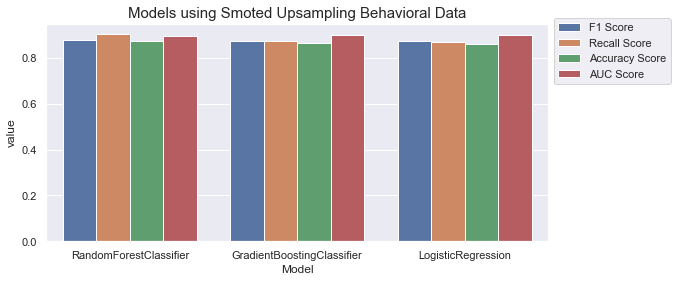

In [132]:
plt.figure(figsize=(9, 4))
plt.title('Models using Smoted Upsampling Behavioral Data',fontsize=15)
ax = sns.barplot(x="Model", y="value", hue = "variable",data=smoted_sort_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05));

In [133]:
smoted_sort_model_df

,Model,variable,value
0,RandomForestClassifier,F1 Score,0.878752
1,GradientBoostingClassifier,F1 Score,0.874814
2,LogisticRegression,F1 Score,0.872867
3,RandomForestClassifier,Recall Score,0.902930
4,GradientBoostingClassifier,Recall Score,0.874420
5,LogisticRegression,Recall Score,0.868476
6,RandomForestClassifier,Accuracy Score,0.873400
7,GradientBoostingClassifier,Accuracy Score,0.864645
8,LogisticRegression,Accuracy Score,0.861800
9,RandomForestClassifier,AUC Score,0.893174


In [134]:
# best smote model performanxce -- gradientboosting
y_pred_smoted=smote_pipelines[1].predict(X_up_test)

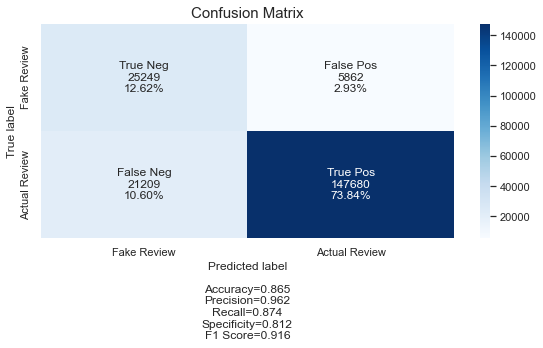

In [135]:
cm_smoted = confusion_matrix(y_up_test,y_pred_smoted )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [136]:
adasyn_pipelines = make_pipeline()
# Train all the models
for pipe in adasyn_pipelines:
    pipe.fit(X_adasyn_train, y_adasyn_train)

In [137]:
# apply sort_models function from above
adasyn_sorted_model = sort_models(adasyn_pipelines, X_up_test, y_up_test)
adasyn_sort_model_df = pd.DataFrame(adasyn_sorted_model)
adasyn_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
adasyn_sort_model_df = pd.melt(adasyn_sort_model_df,id_vars=['Model'])

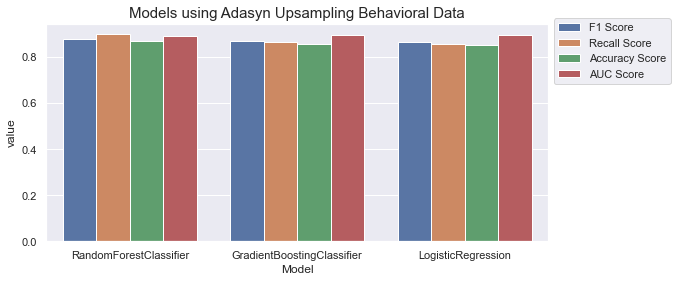

In [138]:
plt.figure(figsize=(9, 4))
ax = sns.barplot(x="Model", y="value", hue = "variable",data=adasyn_sort_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05))
plt.title('Models using Adasyn Upsampling Behavioral Data',fontsize=15);

In [139]:
adasyn_sort_model_df

,Model,variable,value
0,RandomForestClassifier,F1 Score,0.876395
1,GradientBoostingClassifier,F1 Score,0.869196
2,LogisticRegression,F1 Score,0.866582
3,RandomForestClassifier,Recall Score,0.899052
4,GradientBoostingClassifier,Recall Score,0.863496
5,LogisticRegression,Recall Score,0.856527
6,RandomForestClassifier,Accuracy Score,0.870470
7,GradientBoostingClassifier,Accuracy Score,0.857400
8,LogisticRegression,Accuracy Score,0.853740
9,RandomForestClassifier,AUC Score,0.890652


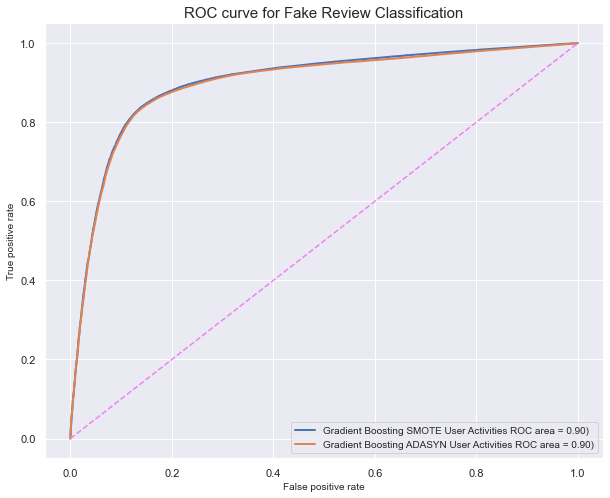

In [140]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10,8))

y_pred_smoted=smote_pipelines[0].predict(X_up_test)

#GradientBoosting Upsampling
fpr_gb1, tpr_gb1, thresholds = roc_curve(y_up_test, smote_pipelines[1].predict_proba(X_up_test)[:,1])
fpr_gb2, tpr_gb2, thresholds = roc_curve(y_up_test, adasyn_pipelines[1].predict_proba(X_up_test)[:,1])
roc_auc_GB_smote=roc_auc_score(y_up_test, smote_pipelines[1].predict_proba(X_up_test)[:,1])
roc_auc_GB_adasyn=roc_auc_score(y_up_test, adasyn_pipelines[1].predict_proba(X_up_test)[:,1])

#GradientBoosting with SMOTE and ADASYN
plt.plot(fpr_gb1, tpr_gb1,lw=2, label='Gradient Boosting SMOTE User Activities ROC area = %0.2f)' % roc_auc_GB_smote)
plt.plot(fpr_gb2, tpr_gb2,lw=2, label='Gradient Boosting ADASYN User Activities ROC area = %0.2f)' % roc_auc_GB_adasyn)



plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc="lower right",ncol=1,fontsize = 'small')
plt.xlabel('False positive rate',fontsize=10)
plt.ylabel('True positive rate',fontsize=10)
plt.title('ROC curve for Fake Review Classification',fontsize=15);

## Best Model

In [141]:
from sklearn.ensemble import GradientBoostingRegressor


# Assume X and y are your input and target variables
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, random_state=3)

# Fit the gradient regression model on the training data
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
# Assume X_train, X_test, y_train, y_test are your training and test sets

GradientBoostingRegressor()

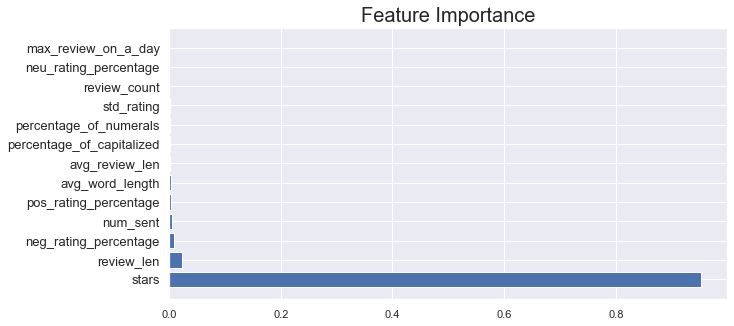

In [142]:
# Retrieve the feature importances and sort them in descending order
feature_importance = pd.DataFrame(list(zip(X_train.columns, gbr.feature_importances_)),
                                  columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Visualize the sorted feature importances in a bar plot
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(feature_importance)), feature_importance['importance'])
plt.yticks(np.arange(len(feature_importance)), feature_importance['feature'], fontsize=13)
plt.title('Feature Importance', fontsize=20)
plt.show()
